In [10]:
import sys, os
import os.path as osp

sys.path.insert(0, osp.abspath(".."))

from models import nnUNet25D, nnUNet3D
from dataloader import Dataloader_3D

import torch
import torch.nn.functional as F
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import vlkit.plt as vlplt
from scipy.io import savemat

from tqdm import tqdm

In [2]:
images = "t2,adc,highb,pz_mask,tz_mask".split(",")

In [12]:
gradients = []
activations = []


train_dataset=Dataloader_3D(data_root="../datasets/recentered_corrected_npy", split='val', fold=0, folds=3)

bs = 8

train_loader=torch.utils.data.DataLoader(
train_dataset,
batch_size=1,
shuffle=False,
num_workers=1,
pin_memory=True,
sampler=None,
drop_last=True)


model = nnUNet3D(5, out_channels=1)

model.load_state_dict(torch.load("../work_dirs/haoxin-data-3dnetwork/ckpt-fold00-epoch023.pt"))



def save_gradient(grad):
    gradients.append(grad)

def forward_hook(module, input, output):
    activations.append(output)
    output.register_hook(save_gradient)

# Register forward hook to a chosen layer
target_layer = model.decoders[-1].basic_module.SingleConv4.conv
target_layer.register_forward_hook(forward_hook)

images = "t2,adc,highb,pz_mask,tz_mask".split(",")

for data in tqdm(train_loader):
    activations.clear()
    gradients.clear()
    mask = data["mask"].bool()
    instance_mask = data["instance_mask"].byte()

    if mask.sum() == 0:
        continue

    # print("mask shape", mask.shape)
    img = torch.cat([data[im] for im in images], dim=1)
    t2 = data["t2"].cpu().numpy()
    img.requires_grad = True

    for ins in instance_mask.unique():
        if ins == 0:
            continue
        inst = instance_mask == ins

        feat, logics = model(img)
        # print(feat.min(), feat.max(), logics.min(), logics.max())
    
        if True:
            voxel_idx = torch.argmax(feat[inst]).item()
            scalar = feat[inst].view(-1)[voxel_idx]
        else:
            scalar = logics.mean()

        model.zero_grad()
        scalar.backward()
        act = activations[0].squeeze(0)
        grad = gradients[0].squeeze(0)

        # Compute weights by GAP over gradients
        weights = grad.mean(dim=(1, 2, 3))  # [C]
        
        # Weighted combination of activations
        cam = torch.zeros_like(act[0])
        for i in range(len(weights)):
            cam += weights[i] * act[i]
    
        # Apply ReLU and normalize
        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cam[None, None,]
        cam = F.interpolate(cam, size=(20, 128, 128), mode='trilinear', align_corners=False).detach().squeeze()
        n = cam.shape[0]
        fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
        vlplt.clear_ticks(axes)
        for i in range(n):
            for j in range(3):
                # t2 on all axes as background
                axes[j, i].imshow(t2[0, 0, i])

            axes[0, i].imshow(cam[i], cmap='jet', alpha=0.5)
            axes[1, i].imshow(inst.squeeze()[i], cmap='jet', alpha=0.5)
            axes[2, i].imshow(logics.detach().squeeze()[i], cmap='jet', alpha=0.5)

            if inst.squeeze()[i].sum() > 0:
                for ax in axes[:, i].flatten():
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red')
                        spine.set_linewidth(2)

        axes[0, 0].set_ylabel("cam")
        axes[1, 0].set_ylabel("inst mask")
        axes[2, 0].set_ylabel("pred")
        plt.tight_layout()
        fn = f"gradcam/test/last-dec-conv/{data['case_id'][0]}-inst{ins:02d}"
        os.makedirs(osp.dirname(fn), exist_ok=True)
        plt.savefig(fn+".jpg")
        plt.close(fig)
        savemat(f"{fn}.mat", {
            "t2": data["t2"].numpy(),
            "adc": data["adc"].numpy(),
            "highb": data["highb"].numpy(),
            "pz_mask": data["pz_mask"].numpy(),
            "tz_mask": data["tz_mask"].numpy(),
            "inst": np.squeeze(instance_mask),
            "cam": cam.numpy(),
        })
        print(f"Done case {data['case_id'][0]} inst {ins:02d}.")

/tmp/ipykernel_850050/3650953776.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../work_dirs/haoxin-data-3dnetwork/ckpt-fold00-epoch0

Done case 1_00A171OX inst 01.
Done case 1_00A171OX inst 02.


  0%|▊                                                                                                                                                                    | 1/217 [01:32<5:31:56, 92.20s/it]


KeyboardInterrupt: 

In [4]:
inst.shape

torch.Size([1, 1, 20, 128, 128])

In [5]:
for i in instance_mask.unique():
    print(i, logics[instance_mask == i].mean())

tensor(0, dtype=torch.uint8) tensor(0.0362, grad_fn=<MeanBackward0>)


In [6]:
# [C, D', H', W']
act = activations[0].squeeze(0)
grad = gradients[0].squeeze(0)

# Compute weights by GAP over gradients
weights = grad.mean(dim=(1, 2, 3))  # [C]

# Weighted combination of activations
cam = torch.zeros_like(act[0])
for i in range(len(weights)):
    cam += weights[i] * act[i]

# Apply ReLU and normalize
cam = torch.relu(cam)
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
cam = cam.detach().numpy()

IndexError: list index out of range

TypeError: 'int' object is not iterable

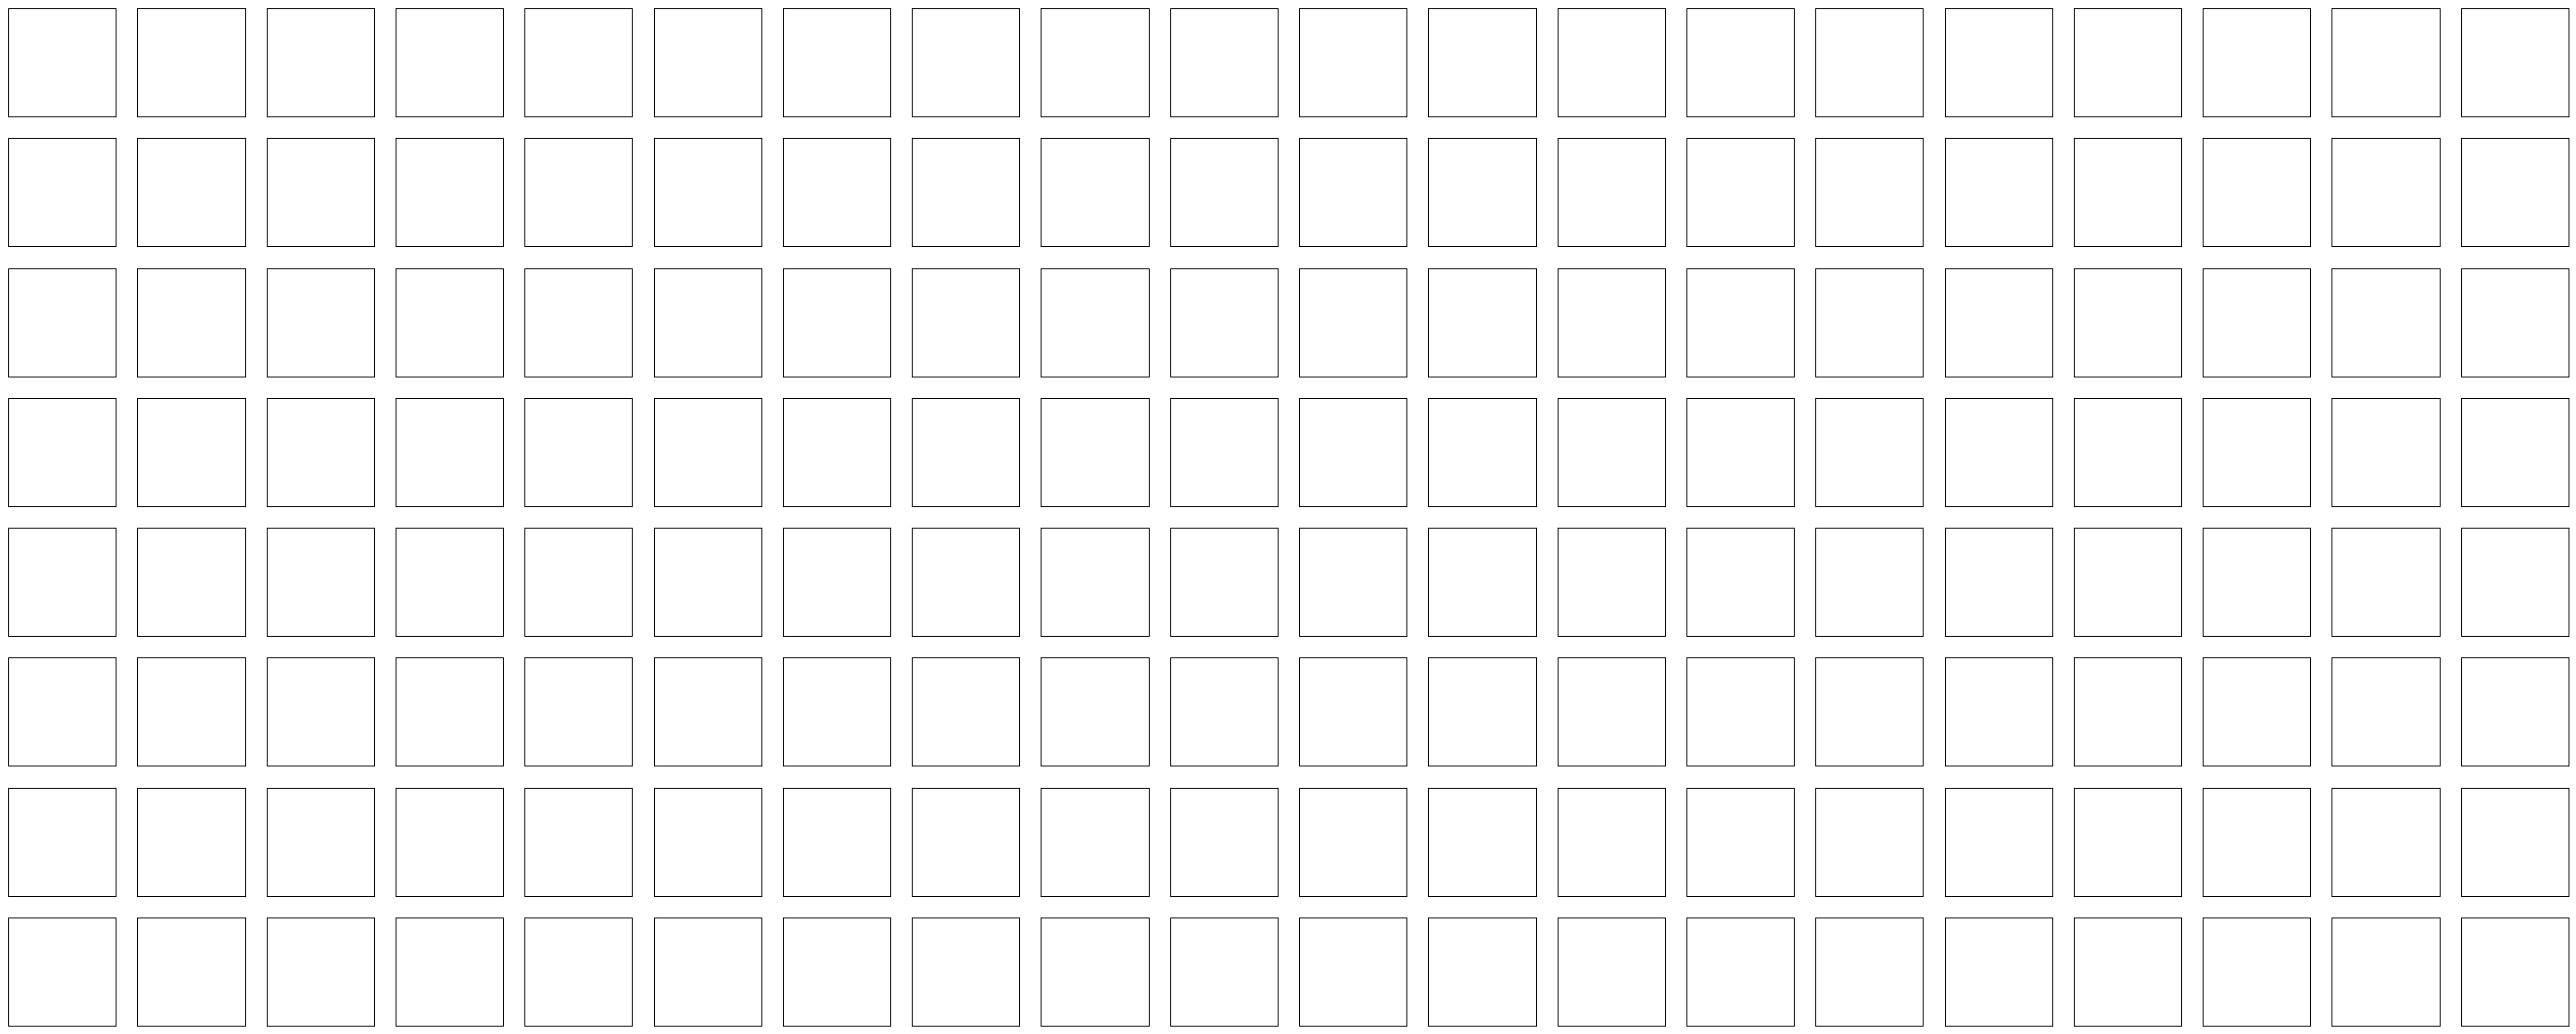

In [7]:
fig, axes = plt.subplots(bs, cam.shape[0], figsize=(cam.shape[0] * 2, bs * 2))
vlplt.clear_ticks(axes)
for b in bs:
    for i in range(cam.shape[0]):
        ax.imshow(cam[i])

In [ ]:
activations[0].shape

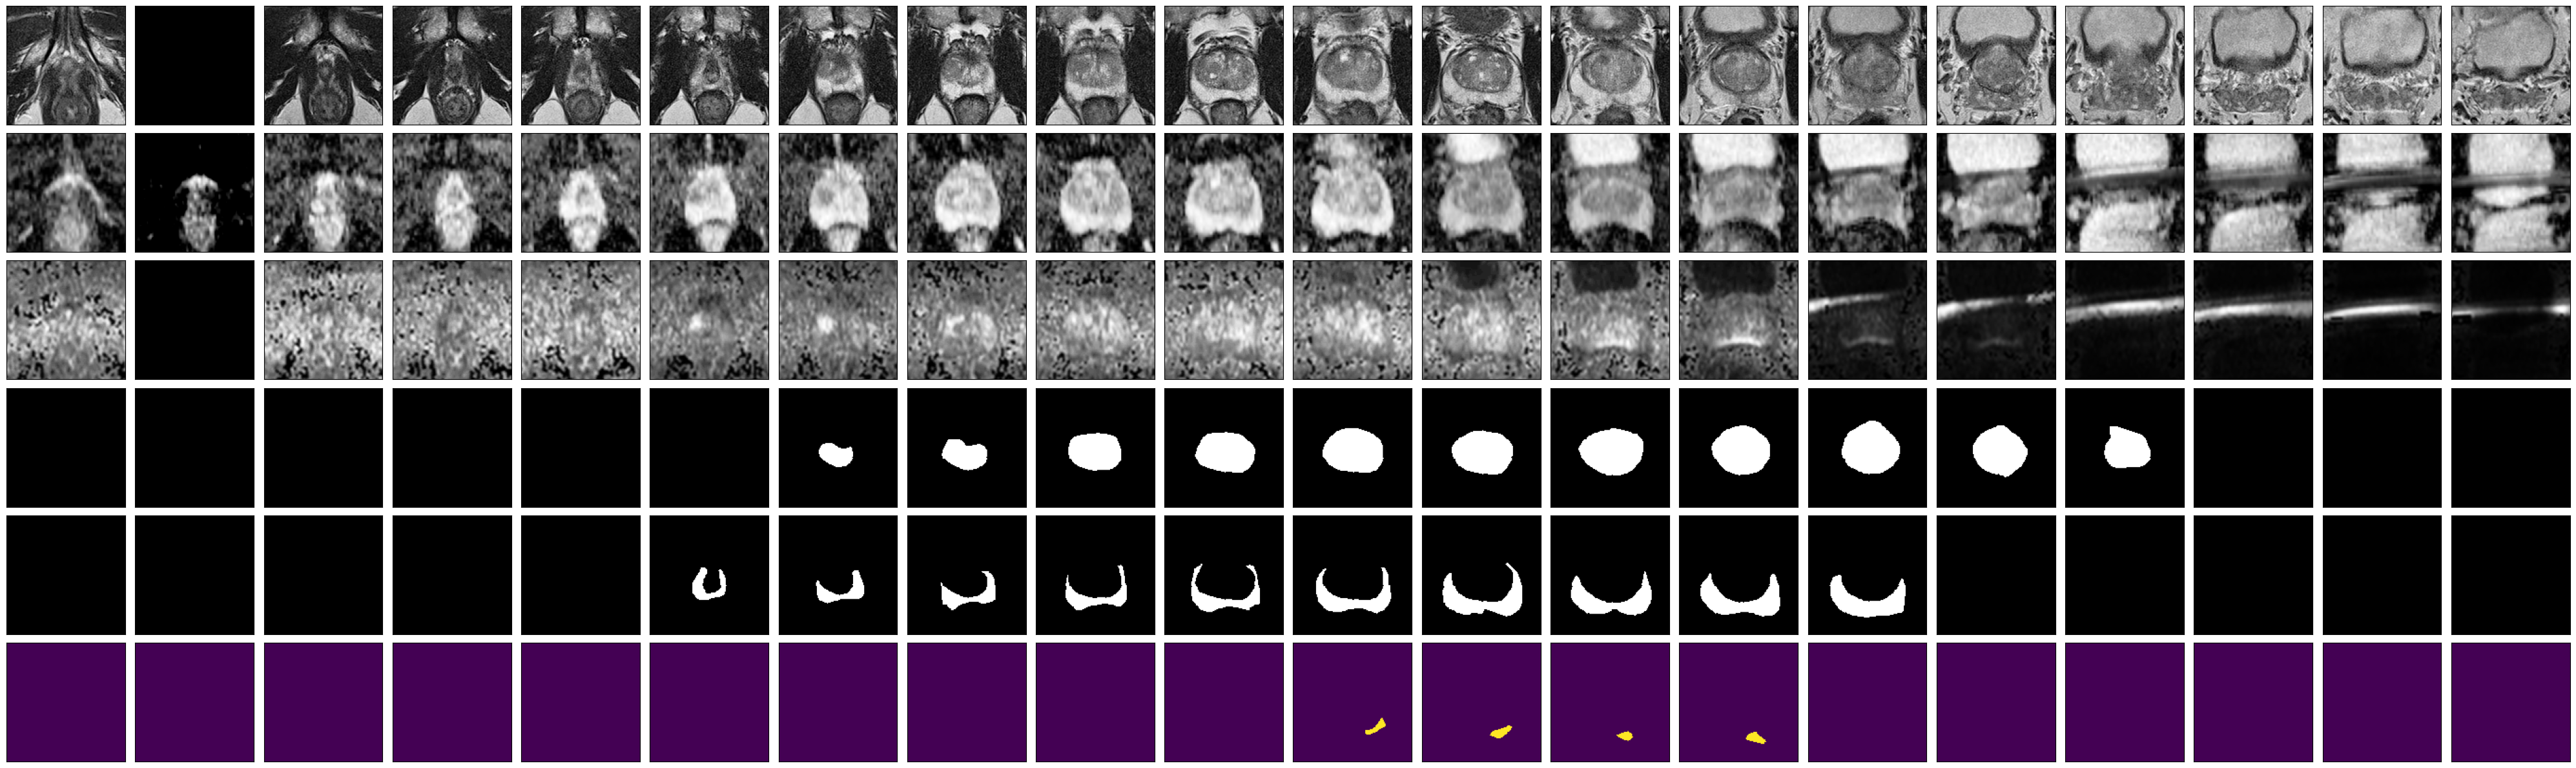

In [136]:
fig, axes = plt.subplots(6, 20, figsize=(40, 12))
vlplt.clear_ticks(axes)

imgnp = img.detach().numpy()

for j in range(20):
    for i in range(5):
        axes[i, j].imshow(imgnp[0, i, j, :, :], cmap="Greys_r")
    axes[5, j].imshow(data["mask"].squeeze()[j])

plt.tight_layout()

In [137]:
data.keys()

dict_keys(['t2', 'adc', 'highb', 'pz_mask', 'tz_mask', 'mask', 'case_id'])

In [64]:
data["mask"].shape

torch.Size([1, 1, 20, 128, 128])